In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Mount Google Drive for accessing datasets
from google.colab import drive
import os
drive.mount('/content/drive')

# Define the base path for data access and create final folder
base_path = '/content/drive/My Drive/CKD_Project/data/'
final_folder = base_path + 'final/'
os.makedirs(final_folder, exist_ok=True)

Mounted at /content/drive


In [ ]:
# 1. Load the dataset
print("Step 1: Loading the dataset")
full_path = base_path + 'Chronic_Kidney_Dsease_data.csv'
df = pd.read_csv(full_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}, Number of features: {df.shape[1]}")

# 2. Select key features needed for CKD prediction
print("\nStep 2: Selecting key features for CKD prediction")
key_features = [
    # Demographics
    'Age', 'Gender', 'BMI',

    # Risk factors
    'Smoking', 'AlcoholConsumption',
    'FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes',
    'PreviousAcuteKidneyInjury',

    # Vital signs
    'SystolicBP', 'DiastolicBP',

    # Lab values - Key indicators
    'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'ACR',

    # Electrolytes
    'SerumElectrolytesSodium', 'SerumElectrolytesPotassium',
    'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus',

    # Blood markers
    'HemoglobinLevels', 'FastingBloodSugar', 'HbA1c',

    # Target variable
    'Diagnosis'
]

# Create a new dataframe with only the selected features
df_selected = df[key_features].copy()
print(f"Selected features: {len(key_features)}")

# Backup original GFR values before any processing
df_selected['Original_GFR'] = df_selected['GFR'].copy()

Step 1: Loading the dataset
Dataset shape: (1659, 54)
Number of samples: 1659, Number of features: 54

Step 2: Selecting key features for CKD prediction
Selected features: 24


In [ ]:
# 3. Check for missing values
print("\nStep 3: Checking for missing values")
missing_values = df_selected.isnull().sum()
print("Missing values in each column:")
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_selected.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values in Dataset')
    plt.tight_layout()
    plt.show()

# 4. Define CKD stages based on GFR values according to clinical guidelines
def define_ckd_stage(gfr):
    """
    Define CKD stage based on GFR value using standard clinical guidelines:
    - Stage 1: GFR ≥ 90 ml/min (Normal kidney function but with other signs of kidney disease)
    - Stage 2: GFR 60-89 ml/min (Mild decrease in kidney function)
    - Stage 3: GFR 30-59 ml/min (Moderate decrease in kidney function)
    - Stage 4: GFR 15-29 ml/min (Severe decrease in kidney function)
    - Stage 5: GFR < 15 ml/min (Kidney failure)
    """
    if gfr >= 90: return 1
    elif gfr >= 60: return 2
    elif gfr >= 30: return 3
    elif gfr >= 15: return 4
    else: return 5

# Add CKD stage as a new column
df_selected['CKDStage'] = df_selected['GFR'].apply(define_ckd_stage)
print("\nCKD Stage distribution:")
print(df_selected['CKDStage'].value_counts().sort_index())


Step 3: Checking for missing values
Missing values in each column:
Age                            0
Gender                         0
BMI                            0
Smoking                        0
AlcoholConsumption             0
FamilyHistoryKidneyDisease     0
FamilyHistoryHypertension      0
FamilyHistoryDiabetes          0
PreviousAcuteKidneyInjury      0
SystolicBP                     0
DiastolicBP                    0
SerumCreatinine                0
BUNLevels                      0
GFR                            0
ProteinInUrine                 0
ACR                            0
SerumElectrolytesSodium        0
SerumElectrolytesPotassium     0
SerumElectrolytesCalcium       0
SerumElectrolytesPhosphorus    0
HemoglobinLevels               0
FastingBloodSugar              0
HbA1c                          0
Diagnosis                      0
Original_GFR                   0
dtype: int64
Total missing values: 0

CKD Stage distribution:
CKDStage
1    454
2    480
3    480
4    245


In [ ]:
# 5. Define and implement hybrid imputation for handling missing values
print("\nStep 5: Implementing hybrid imputation (if needed)")

def hybrid_imputation(data, n_clusters=5):
    """
    Implement hybrid imputation combining clustering with KNN:
    1. Group similar patients using clustering to preserve clinical relationships
    2. Apply KNN imputation within each cluster for more accurate missing value estimation

    This preserves relationships between lab values better than simple mean/median imputation
    """
    # Step 1: Store original data for later reference
    original_data = data.copy()

    # Step 2: Temporarily scale features for clustering only
    numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    data_for_clustering = data.copy()

    # Use RobustScaler to handle outliers better (medical data often has outliers)
    temp_scaler = RobustScaler()
    data_for_clustering[numerical_features] = temp_scaler.fit_transform(
        data_for_clustering[numerical_features].fillna(data_for_clustering[numerical_features].median())
    )

    # Step 3: Apply K-Means clustering
    clustering_features = data_for_clustering.drop(columns=['Diagnosis', 'CKDStage']).select_dtypes(include=['float64', 'int64'])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(clustering_features)

    # Add cluster labels to the original data
    original_data['Cluster'] = clusters

    # Step 4: Apply KNN imputation within each cluster using original values
    imputed_data = original_data.copy()

    for cluster_id in range(n_clusters):
        # Get data for this cluster
        cluster_data = original_data[original_data['Cluster'] == cluster_id]

        # Skip if cluster is empty or has no missing values
        if cluster_data.shape[0] == 0 or cluster_data.isnull().sum().sum() == 0:
            continue

        # Apply KNN imputation within this cluster
        imputer = KNNImputer(n_neighbors=min(5, cluster_data.shape[0]-1))

        # Select features for imputation (exclude Cluster and categorical)
        impute_features = cluster_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
        if 'Cluster' in impute_features:
            impute_features.remove('Cluster')

        # Impute missing values
        imputed_values = imputer.fit_transform(cluster_data[impute_features])

        # Update the imputed data
        imputed_data.loc[cluster_data.index, impute_features] = imputed_values

    # Drop the temporary cluster column
    imputed_data = imputed_data.drop(columns=['Cluster'])

    return imputed_data


# Apply imputation if missing values exist
if missing_values.sum() > 0:
    print("Applying hybrid imputation to handle missing values...")
    df_imputed = hybrid_imputation(df_selected)
    print("Imputation completed.")

    # Recalculate CKDStage using imputed GFR values
    df_imputed['CKDStage'] = df_imputed['GFR'].apply(define_ckd_stage)

    # Verify that missing values have been handled
    missing_after = df_imputed.isnull().sum().sum()
    print(f"Missing values after imputation: {missing_after}")

    # Use the imputed dataframe for further processing
    df_processed = df_imputed
else:
    print("No missing values found. Skipping imputation step.")
    df_processed = df_selected


Step 5: Implementing hybrid imputation (if needed)
No missing values found. Skipping imputation step.


In [ ]:
# 6. Verify and recalculate GFR values using the 2021 CKD-EPI equation
print("\nStep 6: Verifying and recalculating GFR values")

# Save the original data before any changes
df_raw = df_processed.copy()

def calculate_gfr_2021(creatinine, age, is_female):
    """
    Calculate eGFR using 2021 CKD-EPI equation
    This is the most recent clinical standard for estimating kidney function

    Parameters:
    - creatinine: Serum creatinine levels in mg/dL
    - age: Patient age in years
    - is_female: Boolean indicator for female gender

    Returns:
    - Estimated GFR values in mL/min/1.73m²
    """
    creatinine = np.array(creatinine)
    age = np.array(age)
    is_female = np.array(is_female)

    # Gender-specific coefficients
    k = np.where(is_female, 0.7, 0.9)
    alpha = np.where(is_female, -0.241, -0.302)

    # Calculate the terms
    scr_k = creatinine / k
    min_term = np.minimum(scr_k, 1) ** alpha
    max_term = np.maximum(scr_k, 1) ** -1.200

    # Age and gender factors
    age_factor = 0.9938 ** age
    gender_factor = np.where(is_female, 1.012, 1.0)

    # Final GFR calculation
    gfr = 142 * min_term * max_term * age_factor * gender_factor
    return gfr

# Check initial correlation (should be strongly negative)
initial_corr = df_raw['SerumCreatinine'].corr(df_raw['GFR'])
print(f"Initial correlation between Creatinine and GFR: {initial_corr:.4f}")
print(f"Expected: Strong negative correlation (higher creatinine → lower GFR)")

# Recalculate GFR if correlation is not strongly negative
if initial_corr > -0.5:
    print("Recalculating GFR values using 2021 CKD-EPI equation...")

    # Prepare inputs: 1=Female in our dataset
    is_female = np.array(df_raw['Gender'] == 1)
    new_gfr = calculate_gfr_2021(
        df_raw['SerumCreatinine'].values,
        df_raw['Age'].values,
        is_female
    )

    # Update the dataframe
    df_processed = df_raw.copy()
    df_processed['Original_GFR'] = df_processed['GFR'].copy()
    df_processed['GFR'] = new_gfr

    # Recalculate CKD stages with new GFR
    df_processed['CKDStage'] = df_processed['GFR'].apply(define_ckd_stage)

    # Check new correlation
    new_corr = df_processed['SerumCreatinine'].corr(df_processed['GFR'])
    print(f"New correlation after GFR recalculation: {new_corr:.4f}")

    # Show distribution of new CKD stages
    print("\nCKD Stage distribution after GFR recalculation:")
    print(df_processed['CKDStage'].value_counts().sort_index())
else:
    print("GFR values show expected correlation with creatinine. No recalculation needed.")


Step 6: Verifying and recalculating GFR values
Initial correlation between Creatinine and GFR: -0.0034
Expected: Strong negative correlation (higher creatinine → lower GFR)
Recalculating GFR values using 2021 CKD-EPI equation...
New correlation after GFR recalculation: -0.8375

CKD Stage distribution after GFR recalculation:
CKDStage
1    131
2    141
3    362
4    632
5    393
Name: count, dtype: int64


In [ ]:
# 7. Clinical data transformation with appropriate ranges for each parameter
print("\nStep 7: Transforming features with clinical awareness")

# Define consolidated clinical thresholds and ranges based on medical standards
CLINICAL_PARAMETERS = {
    'SerumCreatinine': {
        'min': 0.7, 'max': 1.3, 'method': 'log',
        'outlier_min': 0.5, 'outlier_max': 10.0
    },
    'BUNLevels': {
        'min': 7, 'max': 20, 'method': 'log',
        'outlier_min': 5.0, 'outlier_max': 100.0
    },
    'GFR': {
        'min': 15, 'max': 120, 'method': 'standard',
        'outlier_min': 5.0, 'outlier_max': 130.0
    },
    'ProteinInUrine': {
        'min': 0, 'max': 150, 'method': 'log',
        'outlier_min': 0.0, 'outlier_max': 500.0
    },
    'SerumElectrolytesSodium': {
        'min': 135, 'max': 145, 'method': 'clinical',
        'outlier_min': 125, 'outlier_max': 155
    },
    'SerumElectrolytesPotassium': {
        'min': 3.5, 'max': 5.0, 'method': 'clinical',
        'outlier_min': 2.5, 'outlier_max': 7.0
    },
    'HemoglobinLevels': {
        'min': 12, 'max': 16, 'method': 'standard',
        'outlier_min': 5.0, 'outlier_max': 20.0
    },
    'FastingBloodSugar': {
        'min': 70, 'max': 100, 'method': 'log',
        'outlier_min': 50, 'outlier_max': 400
    },
    'HbA1c': {
        'min': 4, 'max': 5.7, 'method': 'clinical',
        'outlier_min': 3, 'outlier_max': 15
    }
}

# Create working copies of data
df_original = df_processed.copy()
df_transformed = df_processed.copy()

def process_clinical_data(data, params):
    """
    Process clinical data with appropriate transformations while handling outliers
    Each lab value has specific normal ranges and transformation requirements:

    - 'log': Log transformation for right-skewed values like creatinine
    - 'standard': Standardization for normally distributed values
    - 'clinical': Normalization to clinical range
    """
    processed = data.copy()

    # Process features with clinical parameters
    for feature, config in params.items():
        if feature in processed.columns:
            if processed[feature].dtype not in ['float64', 'int64']:
                continue

            # Handle outliers
            print(f"Processing {feature}...")
            original_outliers = ((processed[feature] < config['outlier_min']) |
                               (processed[feature] > config['outlier_max'])).sum()

            processed[feature] = processed[feature].clip(
                config['outlier_min'],
                config['outlier_max']
            )

            print(f"- Outliers handled: {original_outliers} values clipped")

            # Apply transformations
            if config['method'] == 'log':
                processed[feature] = np.log1p(processed[feature])
                print(f"- Log transformation applied")
            elif config['method'] == 'standard':
                scaler = StandardScaler()
                processed[feature] = scaler.fit_transform(processed[[feature]])
                print(f"- Standardization applied")
            elif config['method'] == 'clinical':
                # Normalize to clinical range (0-1 scale)
                processed[feature] = (processed[feature] - config['min']) / (config['max'] - config['min'])
                print(f"- Clinical range normalization applied")

    return processed

# Process the data
original_correlation = df_original['SerumCreatinine'].corr(df_original['GFR'])
print(f"\nOriginal correlation before transformation: {original_correlation:.4f}")

df_transformed = process_clinical_data(df_transformed, CLINICAL_PARAMETERS)
print("\nFeature transformation completed.")

transformed_correlation = df_transformed['SerumCreatinine'].corr(df_transformed['GFR'])
print(f"Correlation after transformation: {transformed_correlation:.4f}")


Step 7: Transforming features with clinical awareness

Original correlation before transformation: -0.8375
Processing SerumCreatinine...
- Outliers handled: 0 values clipped
- Log transformation applied
Processing BUNLevels...
- Outliers handled: 0 values clipped
- Log transformation applied
Processing GFR...
- Outliers handled: 8 values clipped
- Standardization applied
Processing ProteinInUrine...
- Outliers handled: 0 values clipped
- Log transformation applied
Processing SerumElectrolytesSodium...
- Outliers handled: 0 values clipped
- Clinical range normalization applied
Processing SerumElectrolytesPotassium...
- Outliers handled: 0 values clipped
- Clinical range normalization applied
Processing HemoglobinLevels...
- Outliers handled: 0 values clipped
- Standardization applied
Processing FastingBloodSugar...
- Outliers handled: 0 values clipped
- Log transformation applied
Processing HbA1c...
- Outliers handled: 0 values clipped
- Clinical range normalization applied

Feature tr

In [ ]:
# 8. Prepare data for modeling by splitting into features and targets
print("\nStep 8: Preparing data for modeling")

# Features and targets
X = df_transformed.drop(columns=['Diagnosis', 'CKDStage', 'Original_GFR'])
y_diagnosis = df_transformed['Diagnosis']  # Binary CKD diagnosis
y_stage = df_transformed['CKDStage']       # Multi-class CKD stage

# Split into training and testing sets (stratified by CKD stage)
X_train, X_test, y_diag_train, y_diag_test, y_stage_train, y_stage_test = train_test_split(
    X, y_diagnosis, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Save preprocessed data
print("\nStep 9: Saving intermediate preprocessed data")
df_transformed.to_csv(base_path + 'ckd_transformed.csv', index=False)
df_original.to_csv(base_path + 'ckd_original.csv', index=False)

# Save transformation info (for later use/reference)
transformation_info = {
    'feature': list(CLINICAL_PARAMETERS.keys()),
    'method': [params['method'] for params in CLINICAL_PARAMETERS.values()],
    'min_range': [params['min'] for params in CLINICAL_PARAMETERS.values()],
    'max_range': [params['max'] for params in CLINICAL_PARAMETERS.values()]
}
pd.DataFrame(transformation_info).to_csv(base_path + 'transformation_info.csv', index=False)

# Save split data for model training
np.save(base_path + 'X_train.npy', X_train)
np.save(base_path + 'X_test.npy', X_test)
np.save(base_path + 'y_diag_train.npy', y_diag_train)
np.save(base_path + 'y_diag_test.npy', y_diag_test)
np.save(base_path + 'y_stage_train.npy', y_stage_train)
np.save(base_path + 'y_stage_test.npy', y_stage_test)

print("Initial preprocessing data saved successfully.")


Step 8: Preparing data for modeling
Training set size: 1327 samples
Testing set size: 332 samples
Number of features: 23

Step 9: Saving intermediate preprocessed data
Initial preprocessing data saved successfully.


In [ ]:
# 10. Initial Data Validation
print("\nStep 10: Initial Data Validation")

def check_questionable_values(df):
    """
    Check for potentially questionable clinical values that may need verification
    These thresholds are based on extreme clinical values that are rare
    """
    questionable = {
        'SerumCreatinine': df[df['SerumCreatinine'] > 10].shape[0],  # Very high creatinine
        'GFR': df[df['GFR'] < 5].shape[0],                          # Extremely low GFR
        'BUNLevels': df[df['BUNLevels'] > 100].shape[0],            # Very high BUN
        'HemoglobinLevels': df[df['HemoglobinLevels'] < 5].shape[0], # Severe anemia
        'Age': df[df['Age'] > 100].shape[0]                         # Extreme age
    }
    return questionable

print("\nNumber of potentially questionable values (original data):")
questionable_counts = check_questionable_values(df_original)
for feature, count in questionable_counts.items():
    print(f"{feature}: {count} extreme values")


Step 10: Initial Data Validation

Number of potentially questionable values (original data):
SerumCreatinine: 0 extreme values
GFR: 0 extreme values
BUNLevels: 0 extreme values
HemoglobinLevels: 0 extreme values
Age: 0 extreme values



Step 11: Comparing feature distributions before and after transformation


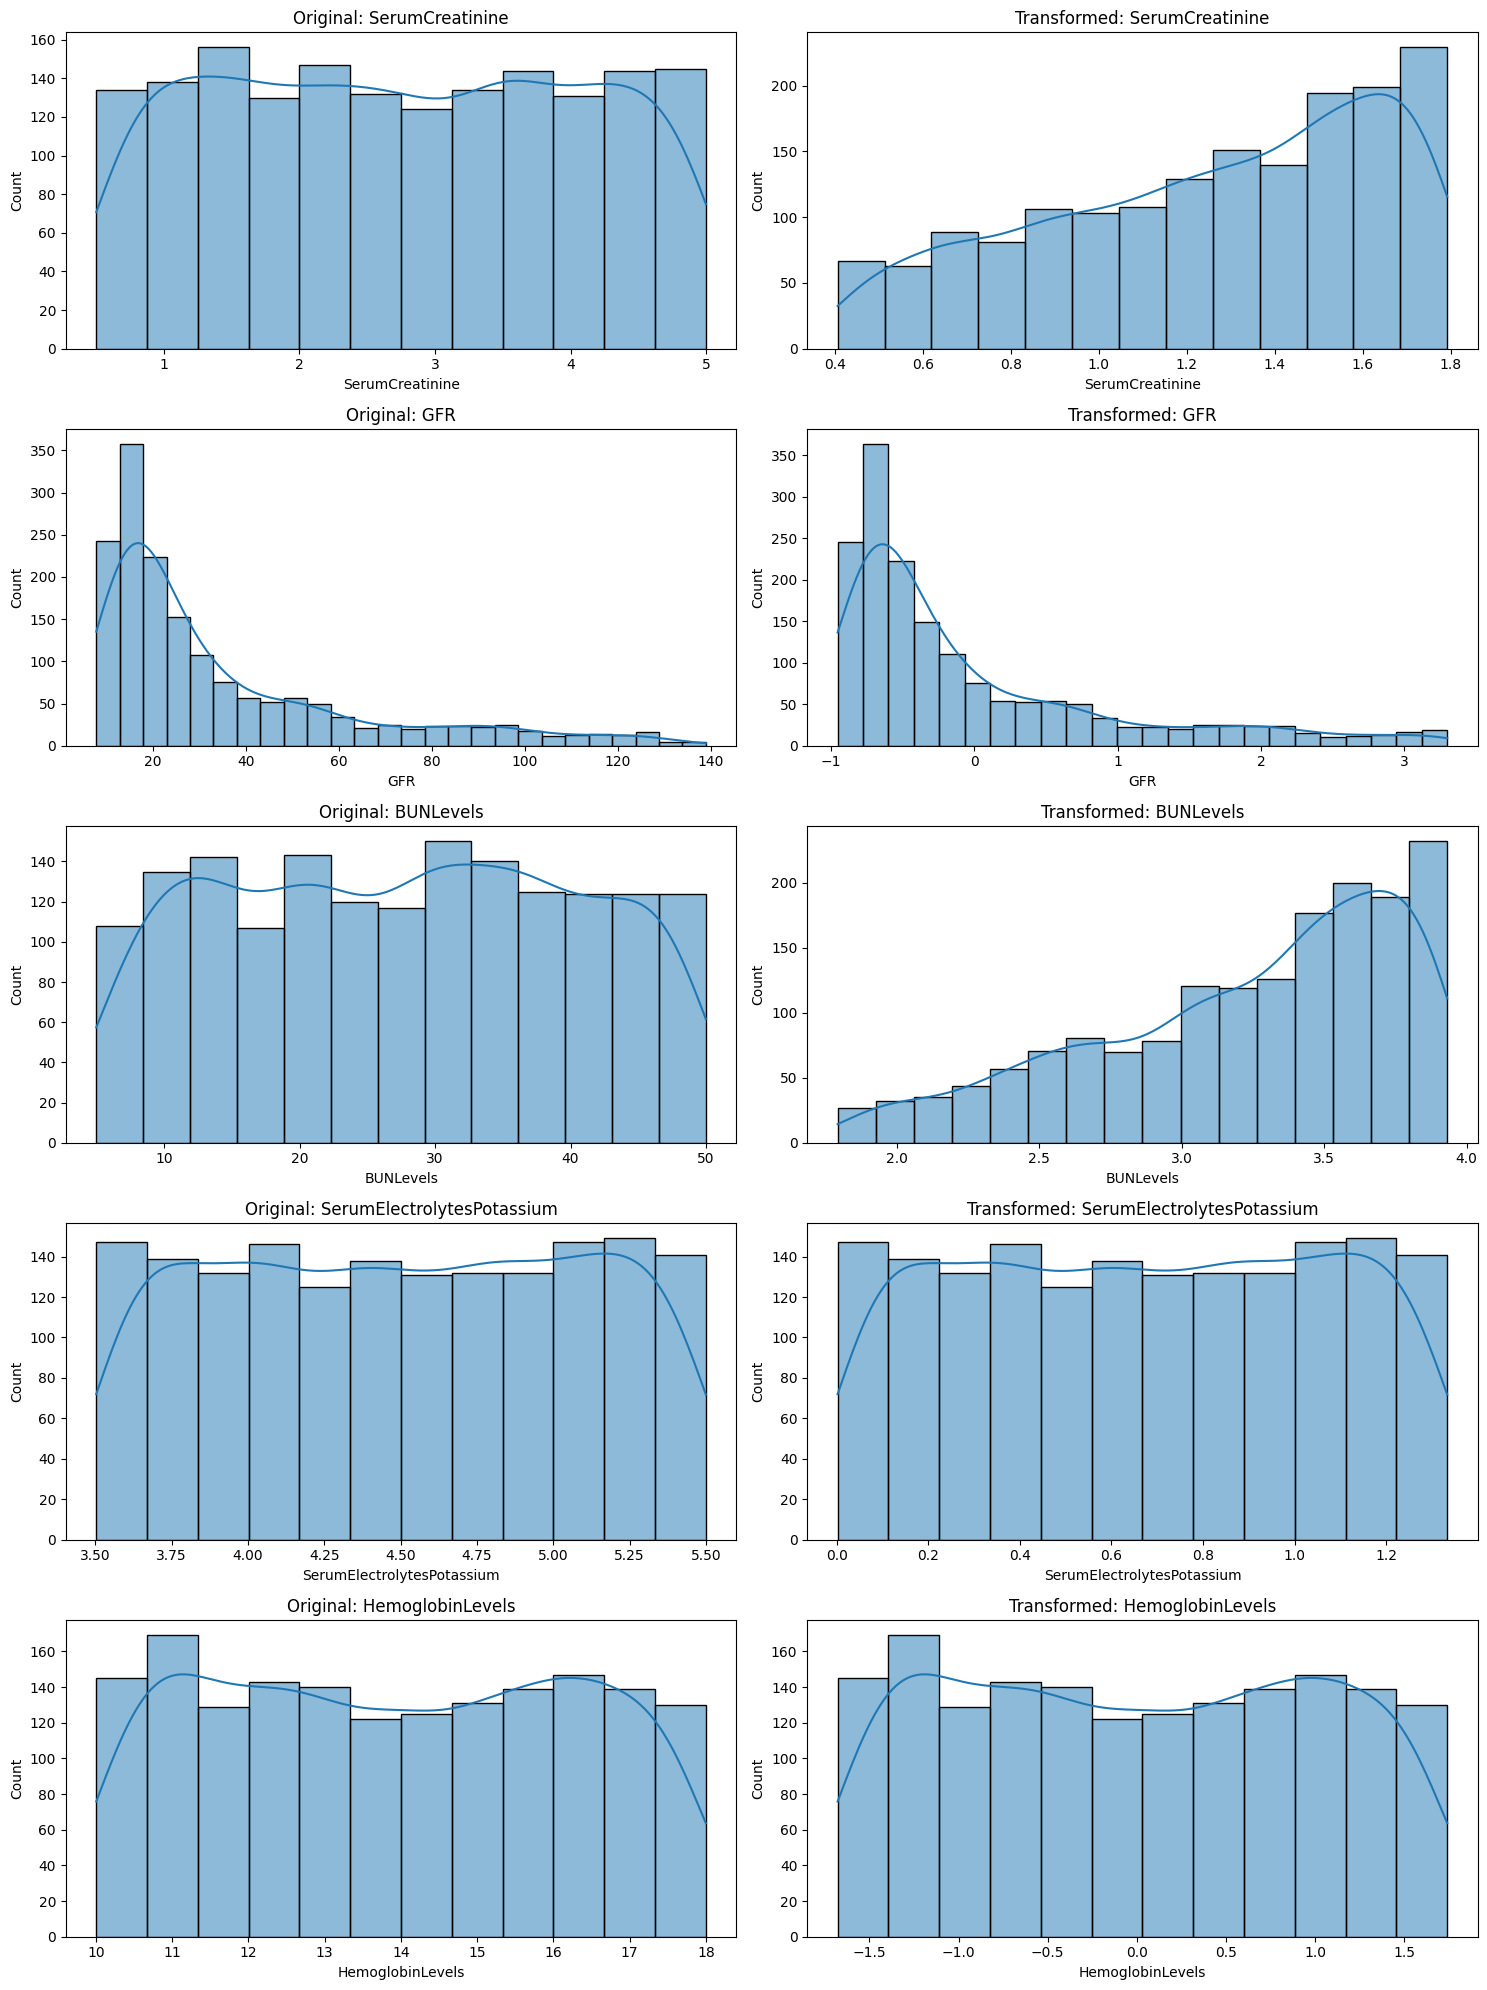

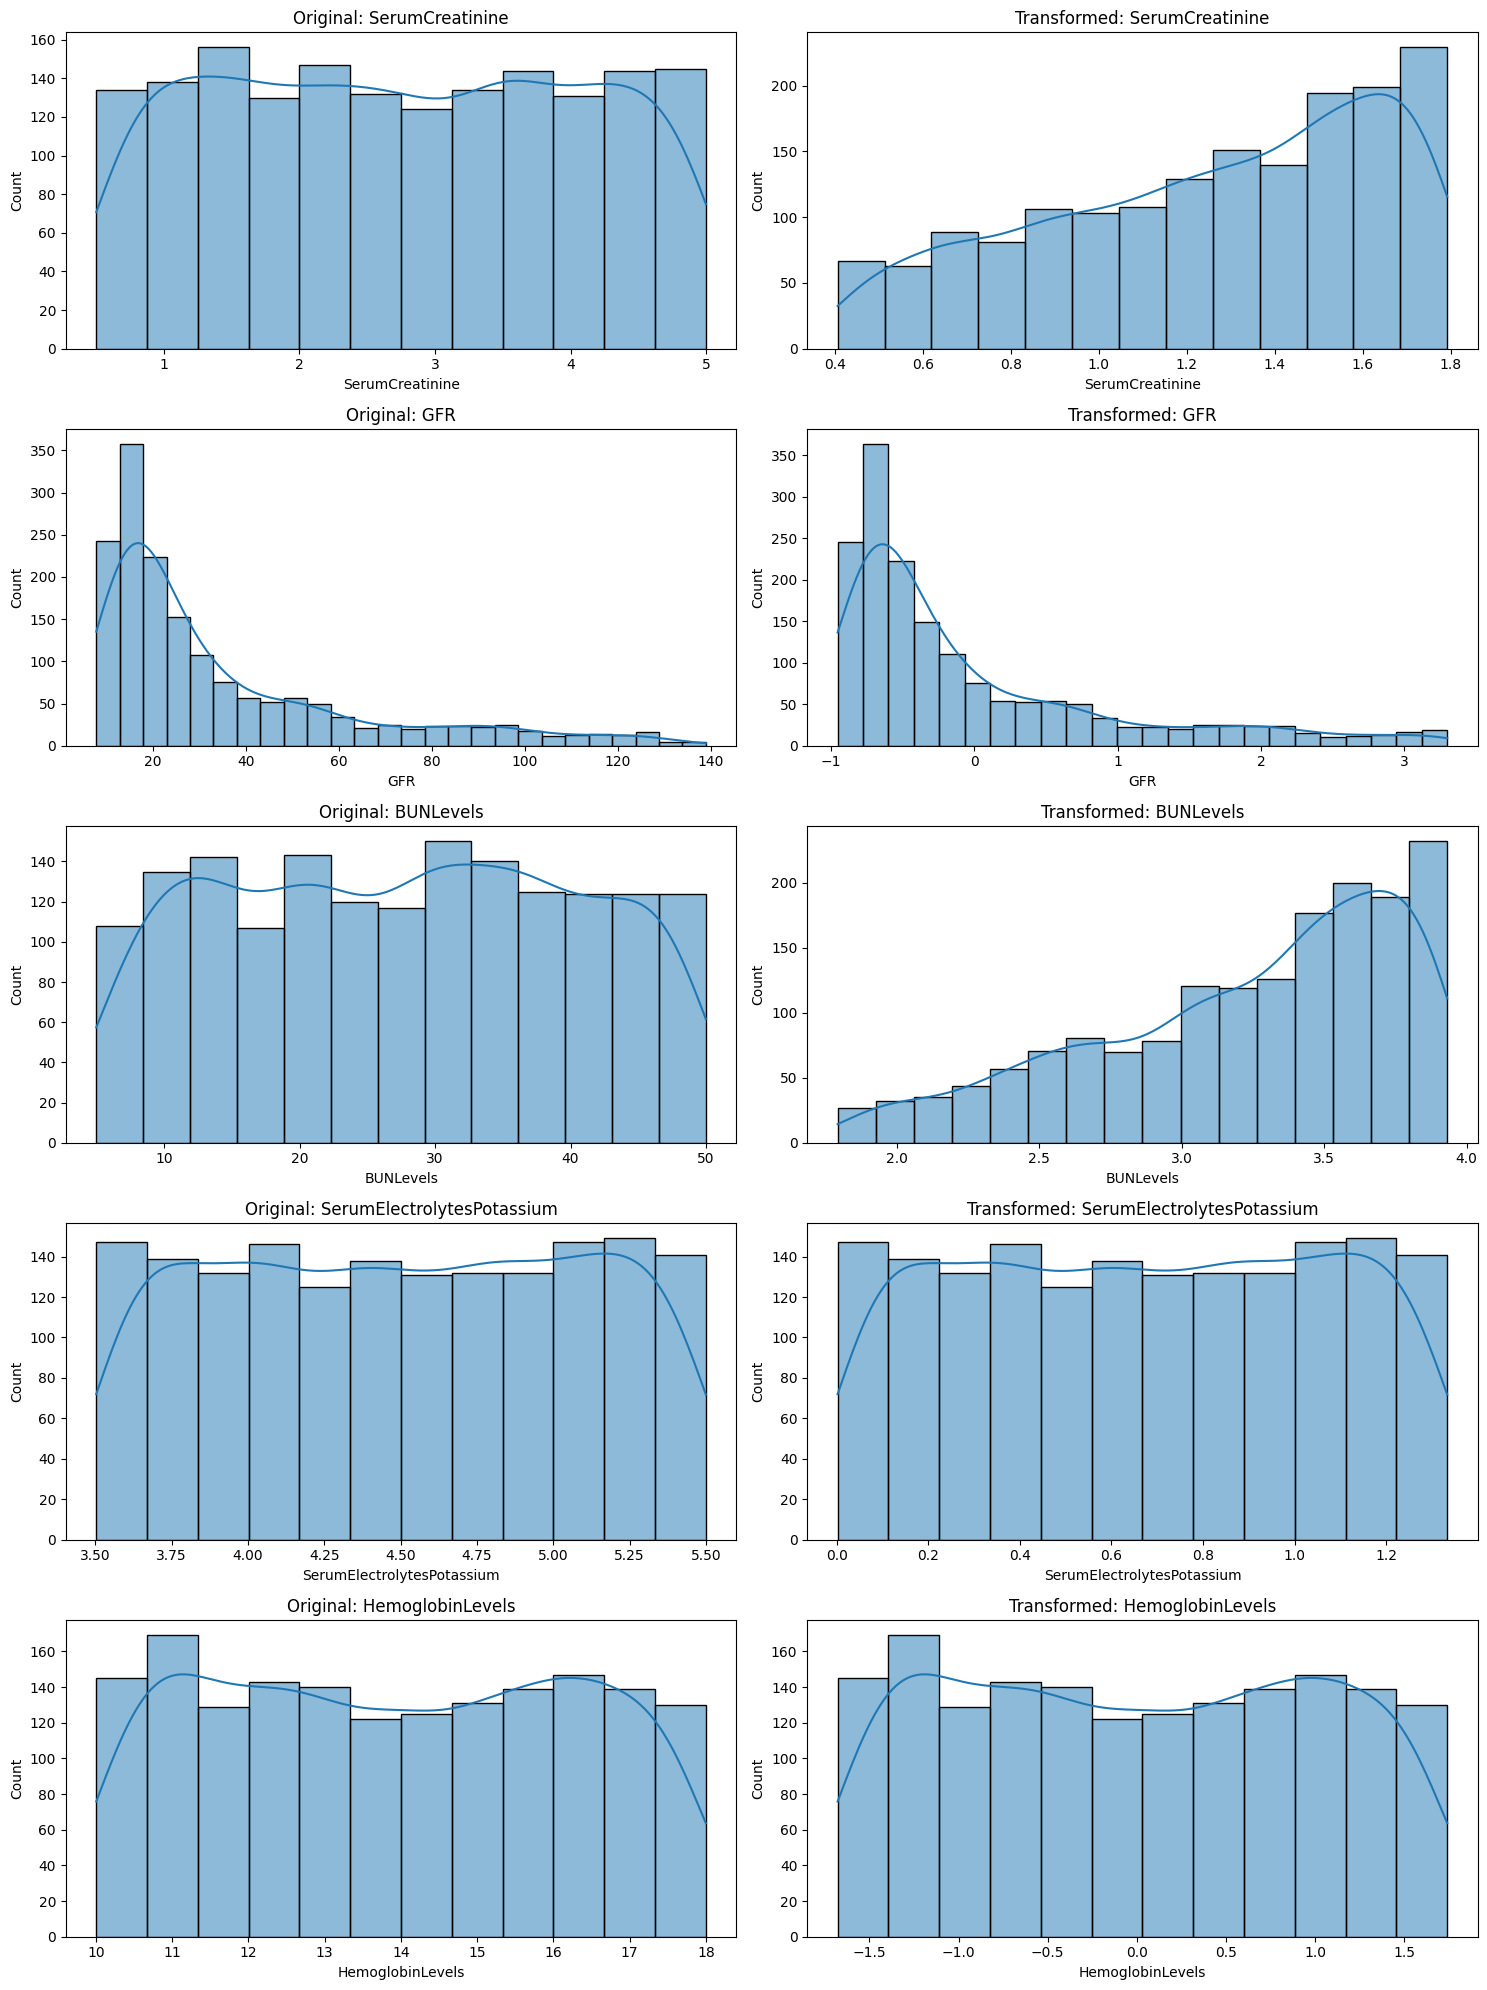

In [ ]:
# 11. Compare distributions of original and transformed features
print("\nStep 11: Comparing feature distributions before and after transformation")

def plot_distribution_comparison(original_data, transformed_data, features):
    """
    comparison of original vs transformed distributions
    validate that the transformations preserved the data structure
    while improving the distribution properties
    """
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 4*n_features))

    for idx, feature in enumerate(features):
        # Original distribution
        sns.histplot(original_data[feature], kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Original: {feature}')

        # Transformed distribution
        sns.histplot(transformed_data[feature], kde=True, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'Transformed: {feature}')

    plt.tight_layout()
    return fig

# Plot key features for visual comparison
key_features = ['SerumCreatinine', 'GFR', 'BUNLevels', 'SerumElectrolytesPotassium', 'HemoglobinLevels']
plot_distribution_comparison(df_original, df_transformed, key_features)


Step 12: Verifying GFR calculation and relationship with Serum Creatinine

Correlation Check:
Original data correlation: -0.8375
Transformed data correlation: -0.9057


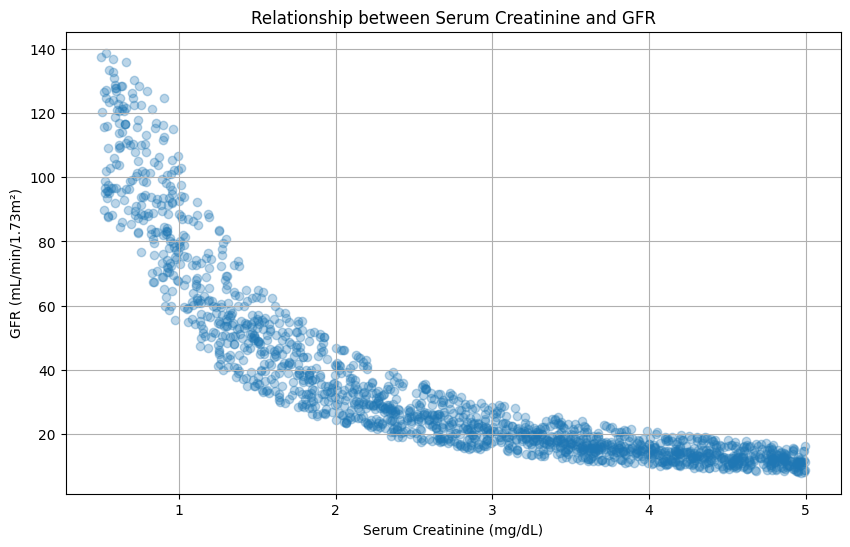


CKD Stage distribution:
CKDStage
1    131
2    141
3    362
4    632
5    393
Name: count, dtype: int64


<ipython-input-10-359b17cf492c>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CKDStage', data=df_original, palette='viridis')


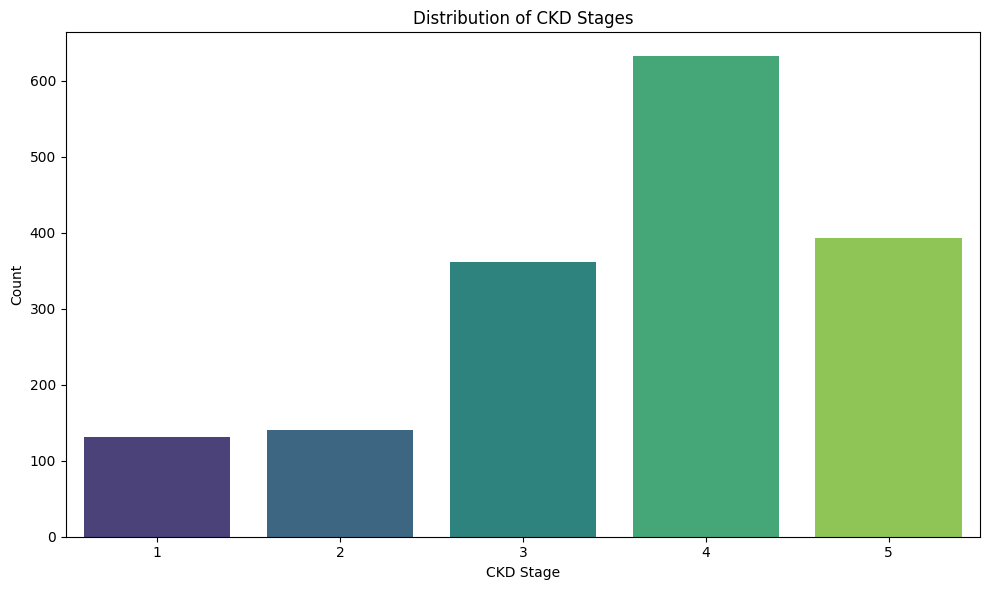

In [ ]:
# 12. Verify GFR relationship with Serum Creatinine
print("\nStep 12: Verifying GFR calculation and relationship with Serum Creatinine")

# Check correlations at different stages
print("\nCorrelation Check:")
original_corr = df_original['SerumCreatinine'].corr(df_original['GFR'])
transformed_corr = df_transformed['SerumCreatinine'].corr(df_transformed['GFR'])
print(f"Original data correlation: {original_corr:.4f}")
print(f"Transformed data correlation: {transformed_corr:.4f}")

# Plot relationship
plt.figure(figsize=(10, 6))
plt.scatter(df_original['SerumCreatinine'], df_original['GFR'], alpha=0.3)
plt.title('Relationship between Serum Creatinine and GFR')
plt.xlabel('Serum Creatinine (mg/dL)')
plt.ylabel('GFR (mL/min/1.73m²)')
plt.grid(True)
plt.show()

# Print CKD stage distribution
print("\nCKD Stage distribution:")
stage_counts = df_original['CKDStage'].value_counts().sort_index()
print(stage_counts)

# Visualize stage distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='CKDStage', data=df_original, palette='viridis')
plt.title('Distribution of CKD Stages')
plt.xlabel('CKD Stage')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# 13. Data Balancing Implementation
print("\nStep 13: Implementing data balancing")

def balanced_preprocessing(df, target_col='Diagnosis', method='weighted', max_ratio=5):
    """
    Balance the dataset to address class imbalance

    Parameters:
    - df: Input dataframe
    - target_col: Target column for balancing
    - method: 'weighted' (assign weights) or 'downsample' (reduce majority class)
    - max_ratio: Maximum allowed ratio between majority and minority class

    Returns:
    - Balanced dataframe and sample weights (if weighted method)
    """
    original_samples = len(df)
    class_counts = df[target_col].value_counts()
    majority_class = class_counts.index[0]
    minority_class = class_counts.index[1]

    print(f"Original dataset size: {original_samples}")
    print(f"Original class distribution:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count} samples ({count/len(df)*100:.2f}%)")

    if method == 'weighted':
        # Assign weights inversely proportional to class frequency
        weights = np.ones(len(df))
        weight_value = class_counts[majority_class] / class_counts[minority_class]
        weights[df[target_col] == minority_class] = weight_value
        df_balanced = df.copy()
        print(f"Using weighted approach: minority class weight = {weight_value:.2f}")

    else:  # Use custom downsampling
        # Reduce majority class while preserving all minority samples
        majority_samples = df[df[target_col] == majority_class]
        minority_samples = df[df[target_col] == minority_class]
        target_majority_size = int(len(minority_samples) * max_ratio)
        majority_downsampled = majority_samples.sample(
            n=min(target_majority_size, len(majority_samples)),
            random_state=42
        )
        df_balanced = pd.concat([majority_downsampled, minority_samples])
        weights = None
        print(f"Downsampled majority class from {len(majority_samples)} to {len(majority_downsampled)}")

    print(f"Final balanced dataset size: {len(df_balanced)}")
    return df_balanced, weights

# Apply balanced preprocessing
df_balanced, sample_weights = balanced_preprocessing(
    df_original,
    method='weighted',
    max_ratio=5
)

# Update dataframes
df_original = df_balanced
df_transformed = df_transformed[df_transformed.index.isin(df_original.index)]


Step 13: Implementing data balancing
Original dataset size: 1659
Original class distribution:
Class 1: 1524 samples (91.86%)
Class 0: 135 samples (8.14%)
Using weighted approach: minority class weight = 11.29
Final balanced dataset size: 1659



Step 14: Performing comprehensive final validation

Final Data Quality Metrics:
Total samples: 1659
Missing values: 0
Features with zero variance: 0


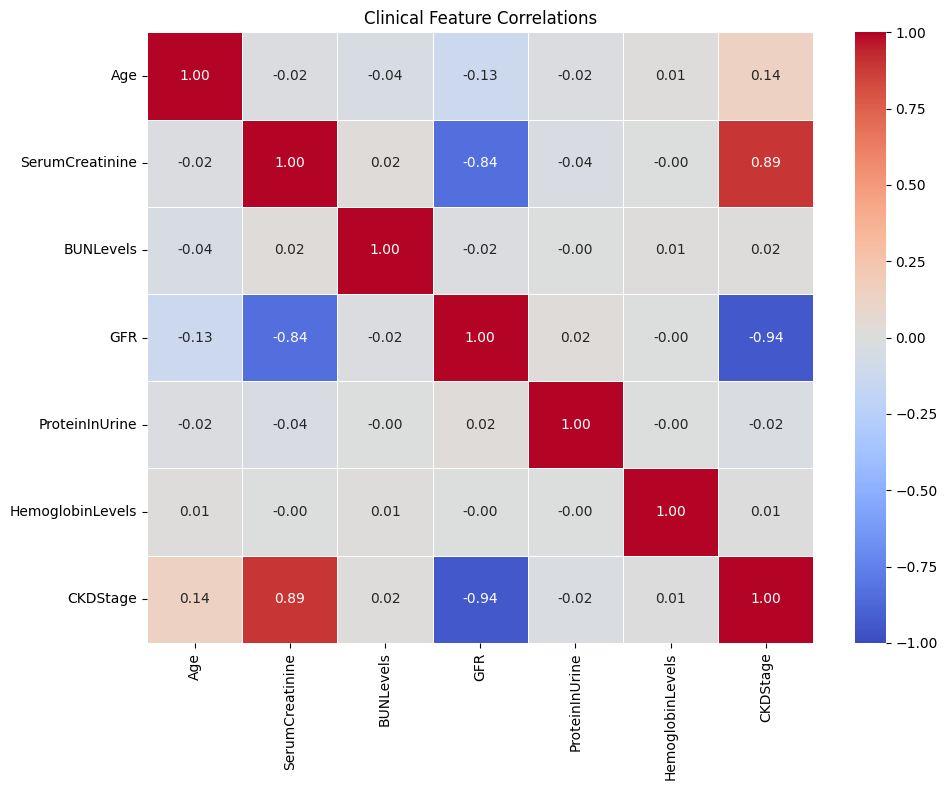


Validating Critical Clinical Relationships:
GFR vs. Creatinine: -0.8375
GFR vs. CKD Stage: -0.9377
BUN vs. Creatinine: 0.0226


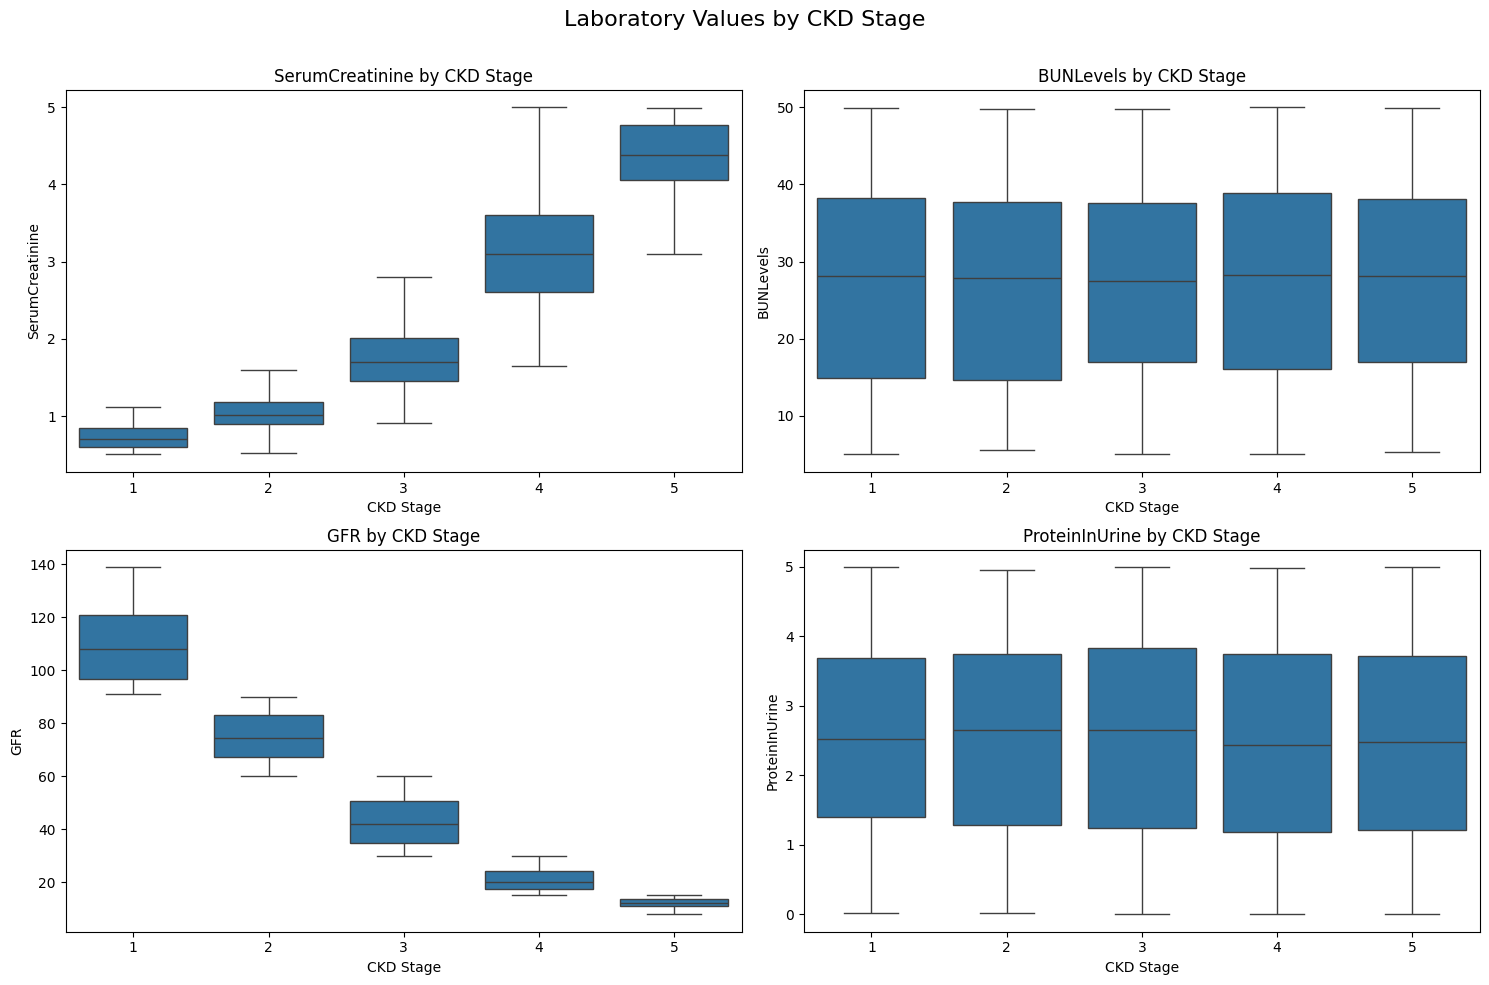

In [ ]:
# 14. Comprehensive Final Validation
print("\nStep 14: Performing comprehensive final validation")

def perform_final_validation(original_data, transformed_data):
    """
    Perform comprehensive final validation of the preprocessed data
    to ensure clinical validity and data quality
    """
    # 1. Data Quality Metrics
    print("\nFinal Data Quality Metrics:")
    print(f"Total samples: {len(original_data)}")
    print(f"Missing values: {original_data.isnull().sum().sum()}")
    print(f"Features with zero variance: {(original_data.std() == 0).sum()}")

    # 2. Clinical Correlations
    key_features = ['Age', 'SerumCreatinine', 'BUNLevels', 'GFR',
                    'ProteinInUrine', 'HemoglobinLevels', 'CKDStage']
    correlation_matrix = original_data[key_features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
                linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
    plt.title('Clinical Feature Correlations')
    plt.tight_layout()
    plt.show()

    # 3. Critical Clinical Relationships
    print("\nValidating Critical Clinical Relationships:")
    critical_correlations = {
        'GFR vs. Creatinine': original_data['GFR'].corr(original_data['SerumCreatinine']),
        'GFR vs. CKD Stage': original_data['GFR'].corr(original_data['CKDStage']),
        'BUN vs. Creatinine': original_data['BUNLevels'].corr(original_data['SerumCreatinine'])
    }

    for relationship, corr in critical_correlations.items():
        print(f"{relationship}: {corr:.4f}")
        if abs(corr) < 0.5:
            print(f"WARNING: Weak correlation for {relationship}")

    # 4. Lab Value Distributions by CKD Stage
    plt.figure(figsize=(15, 10))
    plt.suptitle('Laboratory Values by CKD Stage', fontsize=16)

    key_labs = ['SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine']
    for i, feature in enumerate(key_labs):
        plt.subplot(2, 2, i+1)
        sns.boxplot(x='CKDStage', y=feature, data=original_data)
        plt.title(f'{feature} by CKD Stage')
        plt.xlabel('CKD Stage')
        plt.ylabel(feature)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust for suptitle
    plt.show()

    return critical_correlations

# Execute final validation
validation_results = perform_final_validation(df_original, df_transformed)

In [ ]:
# 15. Create final directory and save all final datasets
print("\nStep 15: Saving final processed datasets to the 'final' folder")

# Create final datasets with clear naming
final_datasets = {
    'ckd_raw_data.csv': df,  # Original unprocessed data
    'ckd_clean_data.csv': df_original,  # Clean data with original values
    'ckd_transformed_data.csv': df_transformed,  # Transformed features
    'transformation_parameters.csv': pd.DataFrame(transformation_info),  # Transformation details
    'ckd_model_data.csv': pd.concat([  # Combined data ready for modeling
        pd.DataFrame(X_train, columns=X.columns),
        pd.DataFrame({'Diagnosis': y_diag_train, 'CKDStage': y_stage_train})
    ]),
    'ckd_test_data.csv': pd.concat([  # Test data for evaluation
        pd.DataFrame(X_test, columns=X.columns),
        pd.DataFrame({'Diagnosis': y_diag_test, 'CKDStage': y_stage_test})
    ])
}

# Save all datasets to the final folder
for filename, dataset in final_datasets.items():
    output_path = final_folder + filename
    dataset.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

# Save numpy arrays for model training
numpy_files = {
    'X_train.npy': X_train,
    'X_test.npy': X_test,
    'y_diag_train.npy': y_diag_train,
    'y_diag_test.npy': y_diag_test,
    'y_stage_train.npy': y_stage_train,
    'y_stage_test.npy': y_stage_test
}

for filename, data in numpy_files.items():
    output_path = final_folder + filename
    np.save(output_path, data)
    print(f"Saved: {output_path}")

# Create a README.txt file explaining the files in the final folder
readme_content = """CKD Data Preprocessing - Final Datasets

Files in this directory:
1. ckd_raw_data.csv - Original unprocessed data
2. ckd_clean_data.csv - Cleaned data with original values (outliers handled)
3. ckd_transformed_data.csv - Data with transformed features ready for modeling
4. transformation_parameters.csv - Details of transformations applied to each feature
5. ckd_model_data.csv - Training data for model development
6. ckd_test_data.csv - Test data for model evaluation
7. X_train.npy, X_test.npy - Feature matrices for training and testing
8. y_diag_train.npy, y_diag_test.npy - Diagnosis targets (binary classification)
9. y_stage_train.npy, y_stage_test.npy - CKD Stage targets (multi-class classification)

This preprocessing pipeline includes:
- Feature selection and cleaning
- GFR calculation using 2021 CKD-EPI equation
- Clinical data transformation with appropriate methods for each lab value
- Class balancing to handle imbalanced data
- Train-test splitting for model development
"""

# Save README file
with open(final_folder + 'README.txt', 'w') as f:
    f.write(readme_content)

print(f"Saved: {final_folder}README.txt")
print("\nPreprocessing completed successfully. All final files are available in the 'final' folder.")


Step 15: Saving final processed datasets to the 'final' folder
Saved: /content/drive/My Drive/CKD_Project/data/final/ckd_raw_data.csv
Saved: /content/drive/My Drive/CKD_Project/data/final/ckd_clean_data.csv
Saved: /content/drive/My Drive/CKD_Project/data/final/ckd_transformed_data.csv
Saved: /content/drive/My Drive/CKD_Project/data/final/transformation_parameters.csv
Saved: /content/drive/My Drive/CKD_Project/data/final/ckd_model_data.csv
Saved: /content/drive/My Drive/CKD_Project/data/final/ckd_test_data.csv
Saved: /content/drive/My Drive/CKD_Project/data/final/X_train.npy
Saved: /content/drive/My Drive/CKD_Project/data/final/X_test.npy
Saved: /content/drive/My Drive/CKD_Project/data/final/y_diag_train.npy
Saved: /content/drive/My Drive/CKD_Project/data/final/y_diag_test.npy
Saved: /content/drive/My Drive/CKD_Project/data/final/y_stage_train.npy
Saved: /content/drive/My Drive/CKD_Project/data/final/y_stage_test.npy
Saved: /content/drive/My Drive/CKD_Project/data/final/README.txt

Pre